# load data

In [1]:
import pandas as pd

df = pd.read_parquet('../results/kis_viability_filt.parquet')

# add drug-cell line combo
df['drug_cell_group'] = df['drug'] + "_" + df['depmap_id']

print('unique drugs:', df['drug'].nunique())
print('unique concs:', df['concentration_M'].nunique())
print('unique cell lines:', df['depmap_id'].nunique())
print('unique drug-cell line combos:', df['drug_cell_group'].nunique())

df

unique drugs: 168
unique concs: 8
unique cell lines: 480
unique drug-cell line combos: 62472


,drug,concentration_M,depmap_id,viability,inh_AAK1,inh_ABL1,inh_ABL2,inh_ACVR1,inh_ACVR1B,inh_ACVR2B,...,inh_TNIK,inh_TNK1,inh_TNK2,inh_TP53RK,inh_TTK,inh_TYK2,inh_ULK1,inh_WEE1,inh_YES1,drug_cell_group
0,AC-480,3.000000e-09,ACH-000007,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,AC-480_ACH-000007
1,AC-480,3.000000e-09,ACH-000011,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,AC-480_ACH-000011
2,AC-480,3.000000e-09,ACH-000019,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,AC-480_ACH-000019
3,AC-480,3.000000e-09,ACH-000021,0.999895,1.000000,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,AC-480_ACH-000021
4,AC-480,3.000000e-09,ACH-000026,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,AC-480_ACH-000026
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
449306,Y-39983,3.000000e-05,ACH-000972,0.977581,0.019503,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,Y-39983_ACH-000972
449307,Y-39983,3.000000e-05,ACH-000973,0.017294,0.019503,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,Y-39983_ACH-000973
449308,Y-39983,3.000000e-05,ACH-000990,0.011341,0.019503,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,Y-39983_ACH-000990
449309,Y-39983,3.000000e-05,ACH-001024,0.110570,0.019503,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,Y-39983_ACH-001024


# 10 fold cv grouped by drug-cell line combo

100%|██████████| 10/10 [07:15<00:00, 43.58s/it]

Random Forest
	R^2 mean: 0.7293262346561398
	R^2 std: 0.002098870481536528
	RMSE mean: 0.17378684610031125
	RMSE std: 0.0007897630262145418
XGBoost
	R^2 mean: 0.7031130721980509
	R^2 std: 0.002749112145683706
	RMSE mean: 0.18200729447161793
	RMSE std: 0.0010104998357814


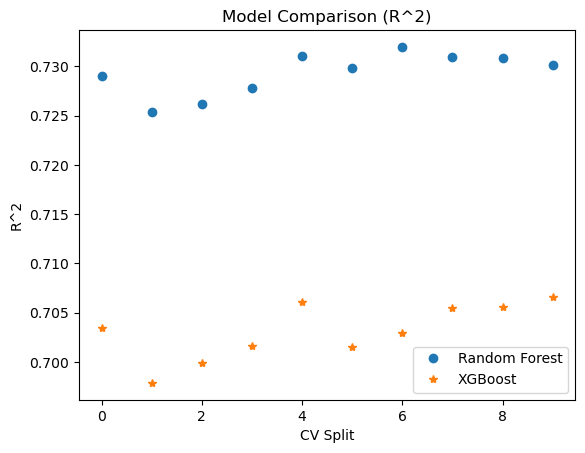

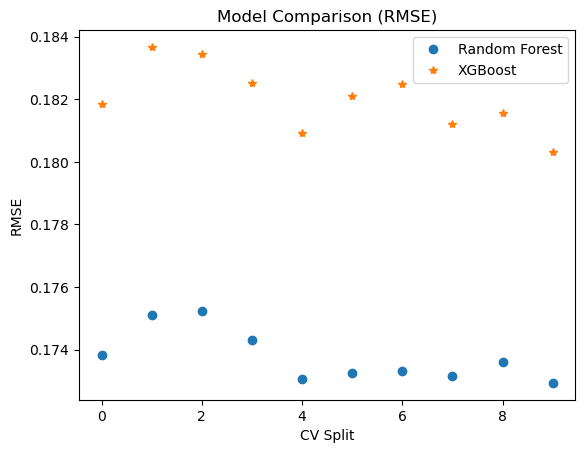

In [2]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GroupKFold
from sklearn.metrics import r2_score, root_mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import tqdm

# X, y, and grouping
X = df.drop(columns=['drug', 'concentration_M', 'depmap_id', 'viability', 'drug_cell_group'])
y = df['viability']
groups = df['drug_cell_group']
gkf = GroupKFold(n_splits=10)

# cv loop
rf_r2 = []
rf_rmse = []
xgb_r2 = []
xgb_rmse = []

for train_index, test_index in tqdm.tqdm(gkf.split(X, y, groups=groups), total=gkf.get_n_splits(X, y, groups=groups)):
    # X, y
    X_train = X.iloc[train_index]
    X_test = X.iloc[test_index]
    y_train = y.iloc[train_index]
    y_test = y.iloc[test_index]

    # model RF
    model_rf = RandomForestRegressor(n_jobs=-1)
    model_rf.fit(X_train, y_train)
    y_pred_rf = model_rf.predict(X_test)
    rf_r2.append(r2_score(y_test, y_pred_rf))
    rf_rmse.append(root_mean_squared_error(y_test, y_pred_rf))

    # model XGB
    model_xgb = XGBRegressor(n_jobs=-1)
    model_xgb.fit(X_train, y_train)
    y_pred_xgb = model_xgb.predict(X_test)
    xgb_r2.append(r2_score(y_test, y_pred_xgb))
    xgb_rmse.append(root_mean_squared_error(y_test, y_pred_xgb))

rf_r2 = np.array(rf_r2)
rf_rmse = np.array(rf_rmse)
xgb_r2 = np.array(xgb_r2)
xgb_rmse = np.array(xgb_rmse)

print('Random Forest')
print('\tR^2 mean:', rf_r2.mean())
print('\tR^2 std:', rf_r2.std())
print('\tRMSE mean:', rf_rmse.mean())
print('\tRMSE std:', rf_rmse.std())

print('XGBoost')
print('\tR^2 mean:', xgb_r2.mean())
print('\tR^2 std:', xgb_r2.std())
print('\tRMSE mean:', xgb_rmse.mean())
print('\tRMSE std:', xgb_rmse.std())

# plot r2
plt.plot(rf_r2, 'o', label='Random Forest')
plt.plot(xgb_r2, '*', label='XGBoost')
plt.xlabel('CV Split')
plt.ylabel('R^2')
plt.title('Model Comparison (R^2)')
plt.legend()
plt.show()

# plot rmse
plt.plot(rf_rmse, 'o', label='Random Forest')
plt.plot(xgb_rmse, '*', label='XGBoost')
plt.xlabel('CV Split')
plt.ylabel('RMSE')
plt.title('Model Comparison (RMSE)')
plt.legend()
plt.show()

# save results to npz
np.savez('../results/baseline_results.npz',
         rf_r2=rf_r2,
         rf_rmse=rf_rmse,
         xgb_r2=xgb_r2,
         xgb_rmse=xgb_rmse)

# RF model from paper
# model = RandomForestRegressor(n_estimators=500, max_features=22, min_samples_leaf=5, n_jobs=-1)

# equivalent, but slower
# from sklearn.model_selection import cross_val_score
# scores_rf = cross_val_score(RandomForestRegressor(n_jobs=-1), X, y, groups=groups, cv=gkf)
# scores_xgb = cross_val_score(XGBRegressor(n_jobs=-1), X, y, groups=groups, cv=gkf)

# OLD

cv: leave one drug out

In [3]:
# from sklearn.model_selection import LeaveOneGroupOut
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import GroupKFold, cross_val_score

# # X, y, and grouing
# X = df.drop(columns=['drug', 'concentration_M',	'depmap_id', 'viability'])
# y = df['viability']
# groups = df['drug']
# logo = LeaveOneGroupOut()

# # model
# model = RandomForestRegressor(n_estimators=500,   # Number of trees
#                               max_features=22,    # Number of predictors to consider at each split
#                               min_samples_leaf=5, # Minimal node size (minimum samples required at a leaf node)
#                               n_jobs=100)#-1)

# # cross validation
# scores = cross_val_score(model, X, y, groups=groups, cv=logo, verbose=1, n_jobs=190-100)#-1)

# # manual cv
# from sklearn.model_selection import LeaveOneGroupOut
# from sklearn.ensemble import RandomForestRegressor
# import tqdm

# # X, y, and grouing
# X = df.drop(columns=['drug', 'concentration_M',	'depmap_id', 'viability'])
# y = df['viability']
# groups = df['drug']
# logo = LeaveOneGroupOut()

# scores_manual = []
# # loop
# for train_index, test_index in tqdm.tqdm(logo.split(X, y, groups=groups), total=logo.get_n_splits(X, y, groups=groups)):
#     # X, y
#     X_train = X.iloc[train_index]
#     X_test = X.iloc[test_index]
#     y_train = y.iloc[train_index]
#     y_test = y.iloc[test_index]

#     # model
#     # model = RandomForestRegressor(n_jobs=-1)
#     model = RandomForestRegressor(n_estimators=500, max_features=22, min_samples_leaf=5, n_jobs=-1)#-1)
#     model.fit(X_train, y_train)
#     # predict
#     y_pred = model.predict(X_test)

#     # score
#     score = model.score(X_test, y_test)
#     scores_manual.append(score)

# # # add group
# # group = []
# # assert len(set(groups.iloc[test_index].values)) == 1
# # group.append(groups.iloc[test_index].values[0])